In [1]:
import sys
sys.path.append("..")
from lib.game import Bilinear2dGame, NonMonotone2dGame
from lib.algorithm import run
import torch
%matplotlib notebook
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 7, 5
plt.rcParams.update({'font.size': 12})
list_colors = ["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:brown", "tab:pink",
               "tab:gray", "tab:cyan", "mediumaquamarine"]
list_markers = ["+", "o", "s",  "x", ">", "*", "d", "h", "v", "^", "<", ]

In [2]:
def plot_grad(game, grid=((-1, 1), (-1, 1)), fig=None):
    if fig is None:
        fig = plt.figure()
    
    if len(fig.axes) < 1:
        ax = fig.add_subplot(111)
    else:
        ax = fig.axes[0]
    
        
    x = torch.linspace(grid[0][0], grid[0][1], 10)
    y = torch.linspace(grid[1][0], grid[1][1], 10)
    grid_x, grid_y = torch.meshgrid(x, y)
    grid_x = grid_x.contiguous().view(-1)
    grid_y = grid_y.contiguous().view(-1)
    grad = []
    for x, y in zip(grid_x, grid_y):
        game.players[0].data = x
        game.players[1].data = y
        g = game.compute_grad(game.sample_batch())
        grad.append((g[0], g[1]))
    grad = -torch.tensor(grad)
    ax.quiver(grid_x, grid_y, grad[:,0], grad[:,1], units='width',color='tab:gray', width=0.002)
        
    return fig

def plot_trajectory(logger, fig=None, subsampling=1, name=None, color=None):
    if fig is None:
        fig = plt.figure()
        
    if len(fig.axes) < 1:
        ax = fig.add_subplot(111)
    else:
        ax = fig.axes[0]
        
    if name is None:
        name = logger["config"]["name"] 
    
    if color is not None:
        marker = list_markers[color]
        color = list_colors[color]
    
    data = []
    for params in logger["params"]:
        data.append((params["players.0"], params["players.1"]))
    data = torch.Tensor(data)
    data = data[::subsampling]
    ax.plot(data[:,0], data[:,1], label=name, color=color, marker=marker, markevery=10, linewidth=2,)
    #ax.scatter(data[-1,0], data[-1,1])
        
    return fig

# 2D Bilinear example

<IPython.core.display.Javascript object>


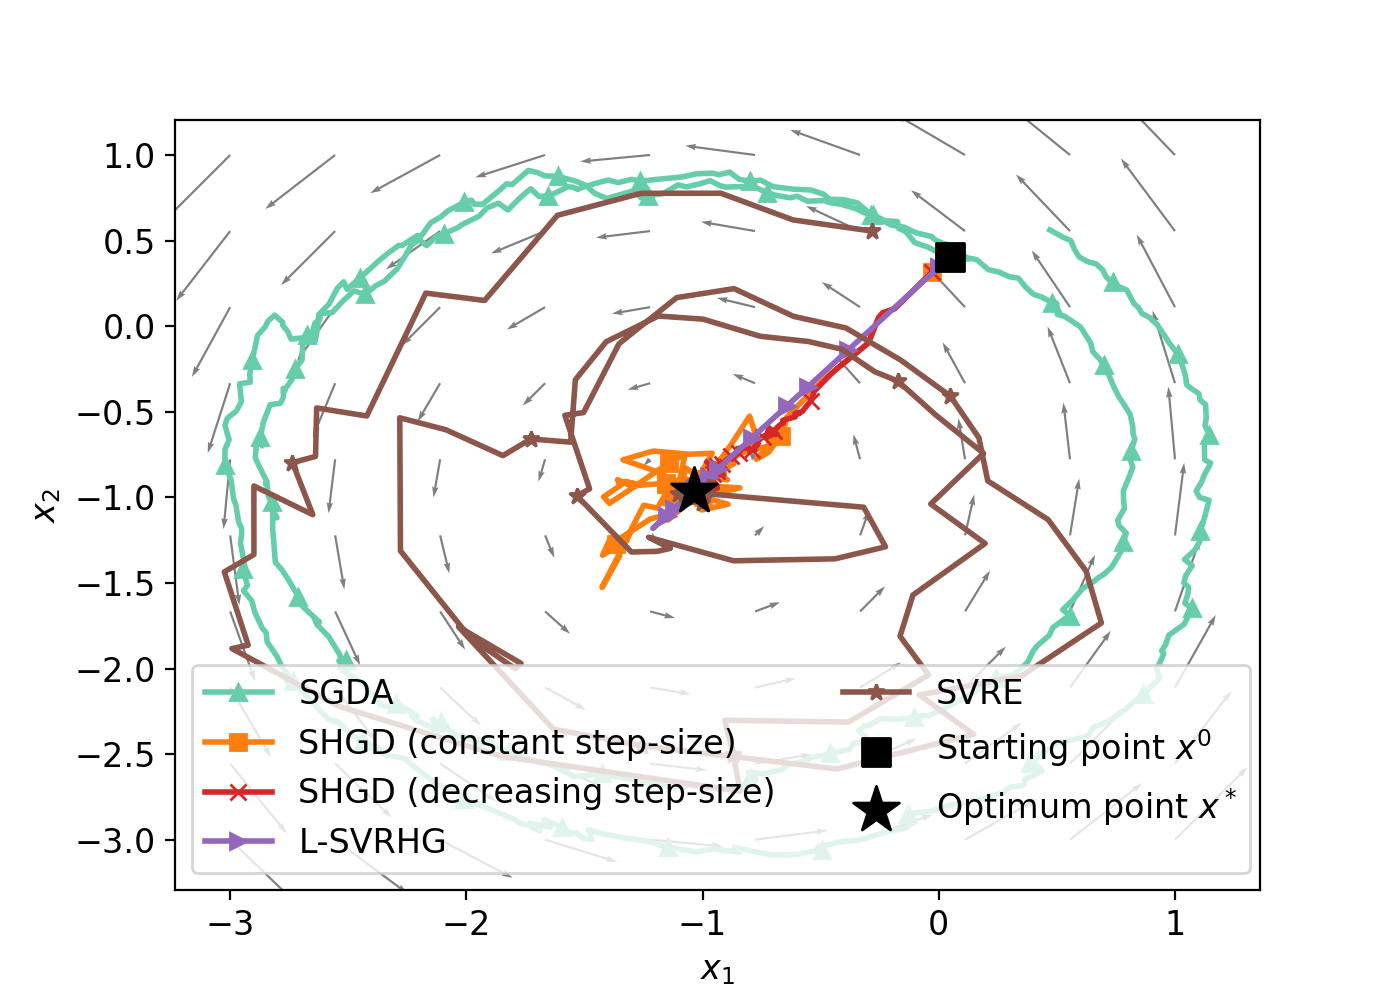

In [3]:
seed = 1234
torch.manual_seed(1234)
num_samples = 100
game = Bilinear2dGame(num_samples, bias=True)
kappa = game.L/game.mu
L = float(game.L)
fig1 = plot_grad(game, grid=((-3, 1), (-3, 1)))
torch.manual_seed(1234)
game.reset()
x_0, y_0 = game.players[0].item(), game.players[1].item()
x_star, y_star = game.solve()

In [4]:
config = dict(output="data", game=game, num_iter=500, seed=1234, save_params=True,
             mode="sgd", lr=0.05)
logger, _ = run(config)
fig = plot_trajectory(logger, fig1, subsampling=1, name="SGDA", color=9)

100%|██████████| 500/500 [00:00<00:00, 713.02it/s]


In [5]:
config = dict(output="data", game=game, num_iter=100, seed=1234, save_params=True,
             mode="shgd", lr=1/(2*L))
logger, _ = run(config)
fig = plot_trajectory(logger, fig1, subsampling=1, name="SHGD (constant step-size)", color=2)

100%|██████████| 100/100 [00:00<00:00, 757.28it/s]


In [6]:
config = dict(output="data", game=game, num_iter=1200, seed=1234, save_params=True,
             mode="shgd", lr=1/(2*L), lr_schedule=5)
logger, _ = run(config)
fig = plot_trajectory(logger, fig1, subsampling=1, name="SHGD (decreasing step-size)", color=3)

100%|██████████| 1200/1200 [00:01<00:00, 774.30it/s]


In [7]:
config = dict(output="data", game=game, num_iter=400, seed=1234, save_params=True,
             mode="svrh", lr=1/(6*L), prob=1/num_samples)
logger, _ = run(config)
fig = plot_trajectory(logger, fig1, subsampling=1, name="L-SVRHG", color=4)

100%|██████████| 400/400 [00:00<00:00, 465.96it/s]


In [8]:
config = dict(output="data", game=game, num_iter=100, seed=1234, save_params=True,
             mode="svre", lr=0.4, prob=1/num_samples, restart=1)
logger, _ = run(config)
fig = plot_trajectory(logger, fig1, subsampling=1, name="SVRE", color=5)

100%|██████████| 100/100 [00:00<00:00, 413.67it/s]


In [9]:
fig1.axes[0].scatter(x_0, y_0, color="black", marker="s", s=100, label="Starting point $x^0$", zorder=100)
fig1.axes[0].scatter(x_star, y_star, color="black", marker="*", s=300, label="Optimum point $x^*$", zorder=100)
fig.axes[0].set_xlabel("$x_1$")
fig.axes[0].set_ylabel("$x_2$")
fig.axes[0].legend(ncol=2)

# 2D Sufficiently-bilinear example

<IPython.core.display.Javascript object>


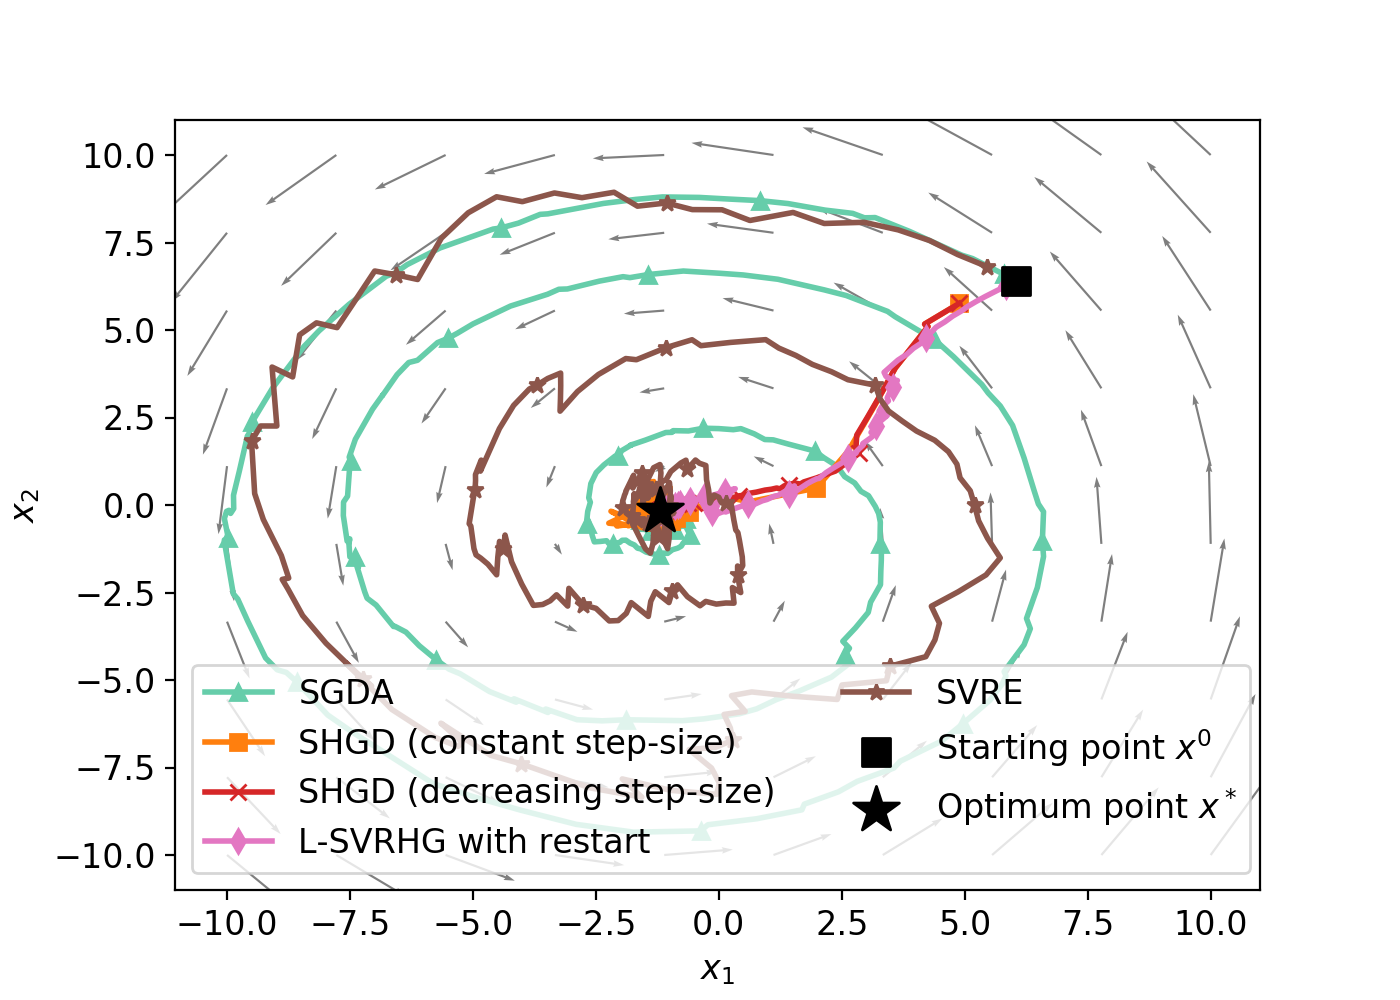

In [10]:
seed = 1234
torch.manual_seed(1234)
num_samples = 100
scale = 7
game = NonMonotone2dGame(num_samples, bias=True, scale=scale)
fig1 = plot_grad(game, grid=((-10, 10), (-10, 10)))
torch.manual_seed(1234)
game.reset()
fig1.axes[0].scatter(game.players[0].item(), game.players[1].item(), color="black", marker="s", s=100, label="Starting point $x^0$", zorder=100)

In [11]:
config = dict(output="data", game=game, num_iter=1000, seed=1234, save_params=True,
             mode="sgd", lr=0.02)
logger, _ = run(config)
fig = plot_trajectory(logger, fig1, subsampling=1, name="SGDA", color=9)

100%|██████████| 1000/1000 [00:03<00:00, 304.33it/s]


In [12]:
config = dict(output="data", game=game, num_iter=200, seed=1234, save_params=True,
             mode="shgd", lr=0.02)
logger, _ = run(config)
fig = plot_trajectory(logger, fig1, subsampling=1, name="SHGD (constant step-size)", color=2)

100%|██████████| 200/200 [00:00<00:00, 295.62it/s]


In [13]:
config = dict(output="data", game=game, num_iter=1700, seed=1234, save_params=True,
             mode="shgd", lr=0.02, lr_schedule=4)
logger, _ = run(config)
fig = plot_trajectory(logger, fig1, subsampling=1, name="SHGD (decreasing step-size)", color=3)

100%|██████████| 1700/1700 [00:05<00:00, 299.42it/s]


In [14]:
config = dict(output="data", game=game, num_iter=500, seed=1234, save_params=True,
             mode="restart-svrh", lr=0.002, prob=1/num_samples, restart=num_samples*10)
logger, _ = run(config)
fig1.axes[0].scatter(x=logger["params"][-1]["players.0"], y=logger["params"][-1]["players.1"], color="black", marker="*", s=300, label="Optimum point $x^*$", zorder=100)
fig = plot_trajectory(logger, fig1, subsampling=1, name="L-SVRHG with restart", color=6)

100%|██████████| 500/500 [00:02<00:00, 180.51it/s]


In [15]:
config = dict(output="data", game=game, num_iter=700, seed=1234, save_params=True,
             mode="svre", lr=0.02, prob=1/num_samples, restart=0.1)
logger, _ = run(config)
fig = plot_trajectory(logger, fig1, subsampling=1, name="SVRE", color=5)

100%|██████████| 700/700 [00:04<00:00, 171.66it/s]


In [16]:
fig.axes[0].set_xlabel("$x_1$")
fig.axes[0].set_ylabel("$x_2$")
fig.axes[0].legend(ncol=2)